In [32]:
import pandas as pd
import boto3
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Set the maximum number of rows and Columns to 200
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [33]:
s3R = boto3.resource("s3")
s3 = boto3.client("s3")
bucket_name = "capstonehaystacks"
# Listing the contents of the S3 bucket
for obj in s3R.Bucket(bucket_name).objects.all():
    print(obj.key)

ACSDP5Y2021.DP04-Data.csv
ACSST5Y2021.S0101-Data.csv
ACSST5Y2021.S0801-Data.csv
ACSST5Y2021.S1901-Data.csv
GA_LISTINGS_SALES.csv
GA_LISTINGS_SALES_V2.csv
GA_listing.csv
all_zips_grocery_store.json
all_zips_restaurant.json
atlanta-geo.csv
atlanta_cbsa_zip.csv
atlanta_hdma_2021.csv
atlanta_hdma_census_2021.csv
atlanta_hdma_tract_2021.csv
atlanta_listings.csv
census_all.csv
census_all_perCapita.csv
census_data
core_geo_dataset.csv
crime.csv
crime_rating_zipcode.csv
elementary_schools.csv
ga_georgia_zip_codes_geo.min.json
high_schools.csv
hmda_2017_ga_all-records_labels.csv
hmda_2021_ga_all-records_labels.csv
jason_listing.csv
listing-with-poi-distances.csv
listings_with_tract.csv
middle_schools.csv
poi-google-exploded.csv
poi_combined_haystack.csv
poi_combined_haystack_ALL.csv
poi_combined_haystack_ALL_CLEANED.csv
poi_expanded.csv
points-of-interest-google.csv
points-of-interest-google2.csv
points-of-interest-google3.csv
points-of-interest-haystacks.csv
schools.csv
zip_summary.csv
zipcode

In [34]:
file_name = "census_all.csv"

# Downloading the file from S3 and parsing it into a dataframe
s3.download_file(bucket_name, file_name, file_name)

# Low memory is set to False because columns have mixed data types
census = pd.read_csv(file_name, index_col=False, low_memory=False)

In [35]:
file_name = "census_all_perCapita.csv"

# Downloading the file from S3 and parsing it into a dataframe
s3.download_file(bucket_name, file_name, file_name)

# Low memory is set to False because columns have mixed data types
census_capita = pd.read_csv(file_name, index_col=False, low_memory=False)

In [36]:
file_name = "atlanta_hdma_2021.csv"

# Downloading the file from S3 and parsing it into a dataframe
s3.download_file(bucket_name, file_name, file_name)

# Low memory is set to False because columns have mixed data types
hdma = pd.read_csv(file_name, index_col=False, low_memory=False)

In [38]:
census_capita.shape

(207, 800)

In [40]:
# filling missing values with 0 which are the restaurants above 4.7 rating and below 4.7 rating
census_capita = census_capita.fillna(0)

In [43]:
# renaming first column
hdma = hdma.rename(columns={hdma.columns[0]: 'zipcode'})

In [76]:
# merging hdma data to census capita
merged_df = pd.merge(census_capita, hdma[['zipcode', 'approval_percentage']], on='zipcode', how='left', suffixes=('', '_hdma'))



In [78]:
# moving columns positions

# list of columns to move them
cols = list(merged_df.columns)

# moving column at index 801 to index 1
cols.insert(1, cols.pop(800))

# reindexing
merged_df = merged_df[cols]

In [105]:
# looking at column names and corrosponding numbers

for idx, column_name in enumerate(merged_df.columns):
    print(f"Column {idx}: {column_name}")

Column 0: approval_percentage
Column 1: car_commute
Column 2: travel_less_10
Column 3: travel_10_14
Column 4: travel_15_19
Column 5: travel_20_24
Column 6: travel_25_29
Column 7: travel_30_34
Column 8: travel_35_44
Column 9: travel_45_59
Column 10: travel_more_60
Column 11: travel_mean
Column 12: percent_male
Column 13: percent_under_15
Column 14: percent_teen_15_19
Column 15: percent_college_20_24
Column 16: percent_25_39
Column 17: percent_40-59
Column 18: percent_over_60
Column 19: rental_vacancy_rate
Column 20: percent_owner_occupied
Column 21: percent_after_2019
Column 22: rent_less_15_percent_income
Column 23: rent_over_30_percent
Column 24: rent_15_30_percent
Column 25: rent_less_999
Column 26: rent_1000_2500
Column 27: rent_over_2500
Column 28: gross_rental_yield
Column 29: percent_less_10k
Column 30: percent_10k_15k
Column 31: percent_15k_25k
Column 32: percent_25k_35k
Column 33: percent_35k_50k
Column 34: percent_50k_75k
Column 35: percent_75k_100k
Column 36: percent_100k_150

In [82]:
# dropping a few columns that are not represented in percentages such as population and income
merged_df = merged_df.drop(merged_df.columns[[2, 3, 15, 23, 25, 26, 36, 47, 48, ]], axis=1)

In [84]:
# making the zip code column the index
merged_df.set_index(merged_df.columns[0], inplace=True)


In [86]:
merged_df.describe()


,approval_percentage,car_commute,travel_less_10,travel_10_14,travel_15_19,travel_20_24,travel_25_29,travel_30_34,travel_35_44,travel_45_59,travel_more_60,travel_mean,percent_male,percent_under_15,percent_teen_15_19,percent_college_20_24,percent_25_39,percent_40-59,percent_over_60,rental_vacancy_rate,percent_owner_occupied,percent_after_2019,rent_less_15_percent_income,rent_over_30_percent,rent_15_30_percent,rent_less_999,rent_1000_2500,rent_over_2500,gross_rental_yield,percent_less_10k,percent_10k_15k,percent_15k_25k,percent_25k_35k,percent_35k_50k,percent_50k_75k,percent_75k_100k,percent_100k_150k,percent_150k_200k,percent_more_200k,accountant_per_Capita,addiction_treatment_center_per_Capita,advertising_agency_per_Capita,after_school_program_per_Capita,air_conditioning_contractor_per_Capita,air_conditioning_repair_service_per_Capita,air_conditioning_system_supplier_per_Capita,air_duct_cleaning_service_per_Capita,allergist_per_Capita,alternative_fuel_station_per_Capita,alternative_medicine_practitioner_per_Capita,american_restaurant_per_Capita,amusement_center_per_Capita,animal_control_service_per_Capita,animal_hospital_per_Capita,antique_furniture_store_per_Capita,antique_store_per_Capita,apartment_building_per_Capita,apartment_complex_per_Capita,apartment_rental_agency_per_Capita,appliance_repair_service_per_Capita,appliance_store_per_Capita,art_center_per_Capita,art_gallery_per_Capita,asian_fusion_restaurant_per_Capita,asian_restaurant_per_Capita,assisted_living_facility_per_Capita,association_or_organization_per_Capita,atm_per_Capita,attorney_per_Capita,audiologist_per_Capita,auto_air_conditioning_service_per_Capita,auto_body_parts_supplier_per_Capita,auto_body_shop_per_Capita,auto_broker_per_Capita,auto_dent_removal_service_per_Capita,auto_electrical_service_per_Capita,auto_glass_shop_per_Capita,auto_insurance_agency_per_Capita,auto_parts_store_per_Capita,auto_radiator_repair_service_per_Capita,auto_repair_shop_per_Capita,auto_restoration_service_per_Capita,auto_tune_up_service_per_Capita,auto_wrecker_per_Capita,automobile_storage_facility_per_Capita,baby_clothing_store_per_Capita,baby_store_per_Capita,bagel_shop_per_Capita,bail_bonds_service_per_Capita,bakery_per_Capita,bank_per_Capita,bankruptcy_attorney_per_Capita,banner_store_per_Capita,banquet_hall_per_Capita,baptist_church_per_Capita,bar_per_Capita,bar_&_grill_per_Capita,barbecue_restaurant_per_Capita,barber_shop_per_Capita,barber_supply_store_per_Capita,...,taco_restaurant_per_Capita,tailor_per_Capita,takeout_restaurant_per_Capita,tanning_salon_per_Capita,tattoo_shop_per_Capita,tax_consultant_per_Capita,tax_preparation_per_Capita,tax_preparation_service_per_Capita,tea_house_per_Capita,teeth_whitening_service_per_Capita,telecommunications_service_provider_per_Capita,telephone_company_per_Capita,temp_agency_per_Capita,tennis_court_per_Capita,tex-mex_restaurant_per_Capita,thai_restaurant_per_Capita,thrift_store_per_Capita,tile_store_per_Capita,tire_shop_per_Capita,tobacco_shop_per_Capita,tool_rental_service_per_Capita,tool_store_per_Capita,topsoil_supplier_per_Capita,tourist_attraction_per_Capita,towing_service_per_Capita,townhouse_complex_per_Capita,toy_store_per_Capita,traditional_american_restaurant_per_Capita,trailer_dealer_per_Capita,trailer_rental_service_per_Capita,trailer_repair_shop_per_Capita,trailer_supply_store_per_Capita,transmission_shop_per_Capita,transportation_service_per_Capita,travel_agency_per_Capita,tree_service_per_Capita,trial_attorney_per_Capita,truck_accessories_store_per_Capita,truck_dealer_per_Capita,truck_parts_supplier_per_Capita,truck_rental_agency_per_Capita,truck_repair_shop_per_Capita,truck_stop_per_Capita,trucking_company_per_Capita,tuxedo_shop_per_Capita,uniform_store_per_Capita,united_methodist_church_per_Capita,university_per_Capita,upholstery_cleaning_service_per_Capita,upholstery_shop_per_Capita,urgent_care_center_per_Capita,urologist_per_Capita,used_auto_parts_store_per_Capita,used_car_dealer_per_Capita,used_tire_shop_per_Capita

In [88]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_rows", 200)

In [133]:
correlation = merged_df.corr()['gross_rental_yield']
correlation.sort_values(ascending=False)

gross_rental_yield              1.000000
percent_35k_50k                 0.530072
travel_mean                     0.433251
travel_more_60                  0.395942
percent_15k_25k                 0.376635
                                  ...   
brunch_restaurant_per_Capita   -0.334049
rent_over_2500                 -0.372600
percent_150k_200k              -0.435349
percent_more_200k              -0.603823
approval_percentage            -0.670343
Name: gross_rental_yield, Length: 791, dtype: float64

In [89]:
correlation = merged_df.corr()['approval_percentage']
correlation.sort_values(ascending=False)


approval_percentage                1.000000
percent_more_200k                  0.589637
percent_150k_200k                  0.525436
pet_boarding_service_per_Capita    0.403316
rent_over_2500                     0.398379
                                     ...   
travel_mean                       -0.354556
percent_50k_75k                   -0.404258
percent_35k_50k                   -0.455684
percent_15k_25k                   -0.466738
gross_rental_yield                -0.670343
Name: approval_percentage, Length: 791, dtype: float64

## Transforming data

In [90]:
# converting the first 29 columns into percentages by dividing by 100
columns_to_divide = list(range(0, 39))
merged_df.iloc[:, columns_to_divide] = merged_df.iloc[:, columns_to_divide] / 100


In [93]:
# adding a new column with total poi's per 1000
merged_df['total_poi_per_1000'] = merged_df.iloc[:, 39:791].sum(axis=1)


In [94]:
# converting POI columns to percent of total. 

columns_to_convert = list(range(39, 791))
total_sum = merged_df.iloc[:, columns_to_convert].sum(axis=1)
merged_df.iloc[:, columns_to_convert] = merged_df.iloc[:, columns_to_convert].div(total_sum, axis=0)


In [96]:
# dropping last column
merged_df = merged_df.drop(columns=merged_df.columns[-1])


In [204]:
pd.set_option("display.max_rows", 200)
merged_df.dtypes

approval_percentage                           float64
car_commute                                   float64
travel_less_10                                float64
travel_10_14                                  float64
travel_15_19                                  float64
                                               ...   
womens_health_clinic_per_Capita               float64
wood_floor_installation_service_per_Capita    float64
yoga_studio_per_Capita                        float64
restaurant_above_4.7_per_Capita               float64
restaurant_below_4.7_per_Capita               float64
Length: 791, dtype: object

In [205]:
# looking into POI's relationship to zip code features

features = merged_df.iloc[:, 0:40]  # Select columns 0-39
target = merged_df['approval_percentage']



# training the linear regression model and evaluate for each column
for col in features.columns:
    X_train, X_test, y_train, y_test = train_test_split(features[col].values.reshape(-1, 1), target, test_size=0.2, random_state=42)

    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)

    score = regression_model.score(X_test, y_test)
    print(f"Column {col} - R-squared: {score}")


Column approval_percentage - R-squared: 1.0
Column car_commute - R-squared: 0.15808780848875692
Column travel_less_10 - R-squared: 0.0032011142389888336
Column travel_10_14 - R-squared: 0.004137021442323197
Column travel_15_19 - R-squared: 0.023571362590292688
Column travel_20_24 - R-squared: 0.04427714294074847
Column travel_25_29 - R-squared: 0.016480909641437447
Column travel_30_34 - R-squared: 0.02237966761800325
Column travel_35_44 - R-squared: -0.06123822945891577
Column travel_45_59 - R-squared: -0.0003397256974579932
Column travel_more_60 - R-squared: 0.10385970695868763
Column travel_mean - R-squared: 0.13553550197916586
Column percent_male - R-squared: 0.054916434365236744
Column percent_under_15 - R-squared: -0.0047510209377377155
Column percent_teen_15_19 - R-squared: 0.031874283863825514
Column percent_college_20_24 - R-squared: -0.007395075287842001
Column percent_25_39 - R-squared: 0.0599850191662773
Column percent_40-59 - R-squared: -0.002923951434227634
Column percent_

In [118]:
# seperating POI information from census info

target_list = [
    "approval_percentage",
    "car_commute",
    "travel_less_10",
    "travel_10_14",
    "travel_15_19",
    "travel_20_24",
    "travel_25_29",
    "travel_30_34",
    "travel_35_44",
    "travel_45_59",
    "travel_more_60",
    "travel_mean",
    "percent_male",
    "percent_under_15",
    "percent_teen_15_19",
    "percent_college_20_24",
    "percent_25_39",
    "percent_40-59",
    "percent_over_60",
    "rental_vacancy_rate",
    "percent_owner_occupied",
    "percent_after_2019",
    "rent_less_15_percent_income",
    "rent_over_30_percent",
    "rent_15_30_percent",
    "rent_less_999",
    "rent_1000_2500",
    "rent_over_2500",
    "gross_rental_yield",
    "percent_less_10k",
    "percent_10k_15k",
    "percent_15k_25k",
    "percent_25k_35k",
    "percent_35k_50k",
    "percent_50k_75k",
    "percent_75k_100k",
    "percent_100k_150k",
    "percent_150k_200k",
    "percent_more_200k"
]


## looking into correlations of POI data with target_list

In [129]:

# list of columns not in target list
other_columns = [column for column in merged_df.columns if column not in target_list]

# correlation between target_list and other_columns
correlation_results = {}

for target_column in target_list:
    correlation_results[target_column] = {}
    for other_column in other_columns:
        correlation = merged_df[target_column].corr(merged_df[other_column])
        correlation_results[target_column][other_column] = correlation

# column with the highest correlation for each column in target_list
highest_correlation = []
for target_column in target_list:
    max_corr_column = max(correlation_results[target_column], key=correlation_results[target_column].get)
    max_corr_value = correlation_results[target_column][max_corr_column]
    highest_correlation.append((target_column, max_corr_column, max_corr_value))

# column with the lowest correlation for each column in target_list
lowest_correlation = []
for target_column in target_list:
    min_corr_column = min(correlation_results[target_column], key=correlation_results[target_column].get)
    min_corr_value = correlation_results[target_column][min_corr_column]
    lowest_correlation.append((target_column, min_corr_column, min_corr_value))

# sorting
highest_correlation.sort(key=lambda x: x[2], reverse=True)
lowest_correlation.sort(key=lambda x: x[2], reverse=True)

# printing results
print("Columns in target_list with highest correlation:")
for pair in highest_correlation:
    print(pair[0], "to", pair[1], "- Correlation:", pair[2])

print("\nColumns in target_list with lowest correlation:")
for pair in lowest_correlation:
    print(pair[0], "to", pair[1], "- Correlation:", pair[2])


Columns in target_list with highest correlation:
percent_college_20_24 to parking_garage_per_Capita - Correlation: 0.679255534058897
travel_20_24 to diner_per_Capita - Correlation: 0.6742404970310261
percent_75k_100k to diner_per_Capita - Correlation: 0.6335052983989902
percent_more_200k to medical_spa_per_Capita - Correlation: 0.6280811878527075
percent_25_39 to apartment_building_per_Capita - Correlation: 0.6158191224537383
percent_teen_15_19 to parking_garage_per_Capita - Correlation: 0.5321941219083857
percent_after_2019 to condominium_complex_per_Capita - Correlation: 0.5288089776028848
rent_1000_2500 to juice_shop_per_Capita - Correlation: 0.5139273323228386
rent_over_2500 to medical_spa_per_Capita - Correlation: 0.4866081020629789
rent_less_999 to convenience_store_per_Capita - Correlation: 0.4845849565223144
percent_35k_50k to janitorial_service_per_Capita - Correlation: 0.45800261039870943
rent_less_15_percent_income to roofing_contractor_per_Capita - Correlation: 0.4541256180

In [132]:


# list of columns not in target lists
other_columns = [column for column in merged_df.columns if column not in target_list]

# correlation between columns in target_list and other_columns
correlation_results = {}

for target_column in target_list:
    correlation_results[target_column] = {}
    for other_column in other_columns:
        correlation = merged_df[target_column].corr(merged_df[other_column])
        if abs(correlation) > 0.5:
            correlation_results[target_column][other_column] = correlation

# printing the columns with correlations above 0.6 or below -0.6
for target_column in correlation_results:
    print("Correlations for", target_column)
    for other_column, correlation in correlation_results[target_column].items():
        print(target_column, "to", other_column, "- Correlation:", correlation)


Correlations for approval_percentage
Correlations for car_commute
car_commute to brunch_restaurant_per_Capita - Correlation: -0.5197475208479778
car_commute to bus_stop_per_Capita - Correlation: -0.5051339126129347
car_commute to cocktail_bar_per_Capita - Correlation: -0.6160590095971716
car_commute to condominium_complex_per_Capita - Correlation: -0.5844483770513671
car_commute to lounge_per_Capita - Correlation: -0.6085463898478433
car_commute to night_club_per_Capita - Correlation: -0.5352046815693997
car_commute to parking_garage_per_Capita - Correlation: -0.6313379184464064
car_commute to vegan_restaurant_per_Capita - Correlation: -0.5024735252514918
car_commute to yoga_studio_per_Capita - Correlation: -0.5098272001472154
Correlations for travel_less_10
Correlations for travel_10_14
Correlations for travel_15_19
Correlations for travel_20_24
travel_20_24 to dentist_per_Capita - Correlation: 0.6258289195398999
travel_20_24 to diner_per_Capita - Correlation: 0.6742404970310261
trave

## Seperating census data from POI data

In [141]:
# dataframe with columns in target_list
target_df = merged_df[target_list]

# dataframe with columns not in target_list
features_df = merged_df.drop(target_list, axis=1)

# KNN

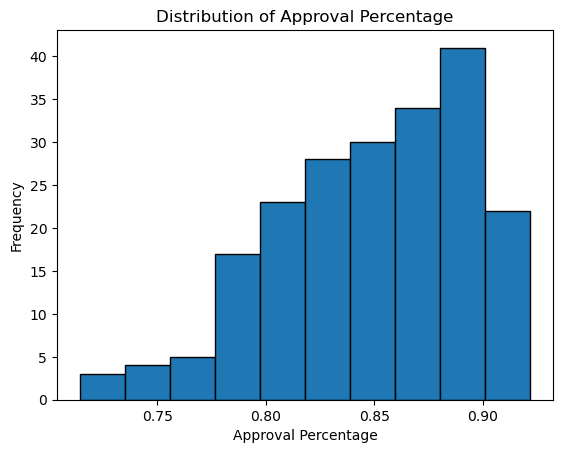

In [143]:
# Creating categories from continous data

# histogram of approval percentage
plt.hist(target_df['approval_percentage'], bins=10, edgecolor='black')

# labels and title
plt.xlabel('Approval Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Approval Percentage')


plt.show()


In [150]:

# defining the category ranges and names
category_ranges = [0, 0.8, 0.85, 0.9, 1]
category_names = ['approv_below_80', 'approv_80_85', 'approv_85_90', 'approve_above_90']

# creating copy of the dataframe and assign category labels based on ranges
target_df_copy = target_df.copy()
target_df_copy['approval_category'] = pd.cut(target_df_copy['approval_percentage'], bins=category_ranges, labels=category_names)


In [159]:
# KNN

X = features_df  # POI columns using to predict target
y = target_df_copy['approval_category']  # new categorical target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)  # creating an instance of KNeighborsClassifier
knn.fit(X_train_scaled, y_train)  # fitting the model to the training data

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1) # zero_division equal to one to prevent errors
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.42857142857142855
Classification Report:
                  precision    recall  f1-score   support

    approv_80_85       0.50      0.69      0.58        13
    approv_85_90       0.39      0.82      0.53        11
 approv_below_80       1.00      0.00      0.00         9
approve_above_90       0.00      0.00      0.00         9

        accuracy                           0.43        42
       macro avg       0.47      0.38      0.28        42
    weighted avg       0.47      0.43      0.32        42



In [162]:
pd.set_option("display.max_rows", None)

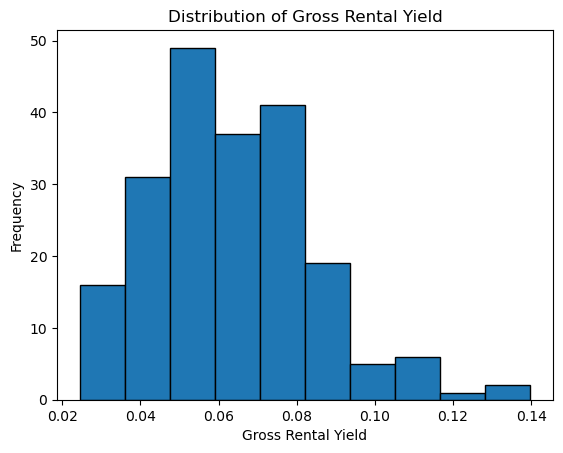

In [207]:
# Creating categories from continous data

# histogram of approval percentage
plt.hist(target_df['gross_rental_yield'], bins=10, edgecolor='black')

# labels and title
plt.xlabel('Gross Rental Yield')
plt.ylabel('Frequency')
plt.title('Distribution of Gross Rental Yield')


plt.show()



In [164]:
# creating categories from continous data

# defining the category ranges and names
category_ranges = [0, 0.04, 0.06, 0.08, float('inf')]
category_names = ['yield_below_0.04', 'yield_0.04_0.06', 'yield_0.06_0.08', 'yield_above_0.08']

# creating a new categorical column based on the 'gross_rental_yield' column
target_df_copy = target_df.copy()
target_df_copy['yield_category'] = pd.cut(target_df_copy['gross_rental_yield'], bins=category_ranges, labels=category_names)


In [165]:
X = features_df  
y = target_df_copy['yield_category']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)  
knn.fit(X_train_scaled, y_train)  

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, zero_division=1)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.3333333333333333
Classification Report:
                  precision    recall  f1-score   support

 yield_0.04_0.06       0.41      0.54      0.47        13
 yield_0.06_0.08       0.29      0.58      0.39        12
yield_above_0.08       0.00      0.00      0.00        11
yield_below_0.04       1.00      0.00      0.00         6

        accuracy                           0.33        42
       macro avg       0.43      0.28      0.21        42
    weighted avg       0.35      0.33      0.26        42



In [ ]:
car_commute

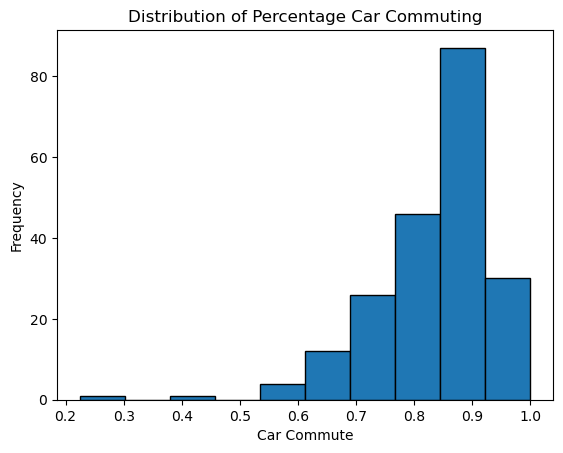

In [208]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(target_df['car_commute'], bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Car Commute')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Car Commuting')

# Display the histogram
plt.show()


In [209]:

# creating equal bins for categorical commuting data
num_bins = 4

# making equal size bin boundaries
bin_boundaries = np.linspace(target_df_copy['car_commute'].min(), target_df_copy['car_commute'].max(), num_bins + 1)

# defining the category names based on range
category_names = [f'commute_{bin_boundaries[i]:.2f}_{bin_boundaries[i+1]:.2f}' for i in range(num_bins)]

# creating a copy of the dataframe and assign category labels based on equal size bins
target_df_copy['car_commute_category'] = pd.cut(target_df_copy['car_commute'], bins=bin_boundaries, labels=category_names)


In [210]:
# filling in a missing value
target_df_copy['car_commute_category'] = target_df_copy['car_commute_category'].fillna('commute_0.22_0.42')


# I think below is what we want

In [213]:
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# X = features_df  # Your feature columns
# y = target_df_copy['car_commute_category']  # The new categorical target column

# # Assuming you have a single target row for which you want to find similar rows
# target_row = X.iloc[0].values  # Assuming the first row as the target and extracting the values

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Calculate distances to find similar rows
# neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')  # Choose the value of K and distance metric
# neigh.fit(X_scaled)
# distances, indices = neigh.kneighbors(scaler.transform([target_row]))  # Pass target_row as a list

# similar_rows = X.iloc[indices[0]]

# print("Target Row:")
# print(target_row)
# print("\nSimilar Rows:")
# print(similar_rows)



Target Row:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01492537
 0.         0.         0.00746269 0.         0.         0.01492537
 0.00746269 0.00746269 0.         0.         0.00746269 0.00746269
 0.         0.00746269 0.         0.         0.00746269 0.
 0.         0.         0.         0.00746269 0.         0.
 0.         0.         0.00746269 0.         0.         0.
 0.         0.         0.00746269 0.         0.         0.
 0.         0.00746269 0.00746269 0.         0.         0.
 0.00746269 0.00746269 0.05970149 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00746269 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01492537 0.         0.         0.02238806
 0.         0.01492537 0.         0.         0.         0.
 0.         0.         0.         0.00746269 0.         0.
 0.00746269 

/Users/jasonphillip/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [214]:
target_row

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01492537, 0.        , 0.        , 0.00746269,
       0.        , 0.        , 0.01492537, 0.00746269, 0.00746269,
       0.        , 0.        , 0.00746269, 0.00746269, 0.        ,
       0.00746269, 0.        , 0.        , 0.00746269, 0.        ,
       0.        , 0.        , 0.        , 0.00746269, 0.        ,
       0.        , 0.        , 0.        , 0.00746269, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00746269,
       0.        , 0.        , 0.        , 0.        , 0.00746269,
       0.00746269, 0.        , 0.        , 0.        , 0.00746269,
       0.00746269, 0.05970149, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00746269, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [211]:
X = features_df  # Your feature columns
y = target_df_copy['car_commute_category']  # The new categorical target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)  # Create an instance of KNeighborsClassifier
knn.fit(X_train_scaled, y_train)  # Fit the model to the training data

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.7142857142857143
Classification Report:
                   precision    recall  f1-score   support

commute_0.42_0.61       1.00      0.00      0.00         2
commute_0.61_0.81       0.43      0.27      0.33        11
commute_0.81_1.00       0.77      0.93      0.84        29

         accuracy                           0.71        42
        macro avg       0.73      0.40      0.39        42
     weighted avg       0.69      0.71      0.67        42



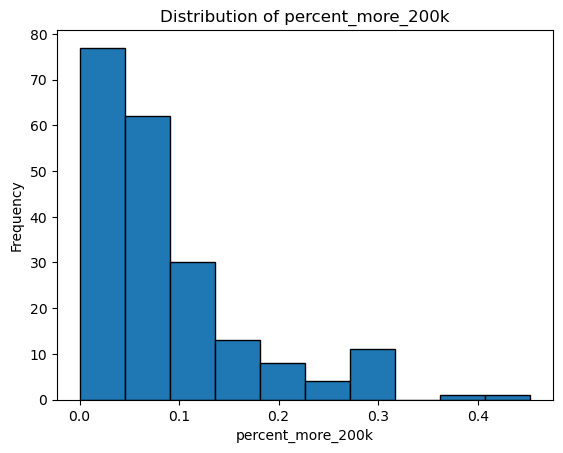

In [180]:
# creating histogram
plt.hist(target_df['percent_more_200k'], bins=10, edgecolor='black')

# labels and title
plt.xlabel('percent_more_200k')
plt.ylabel('Frequency')
plt.title('Distribution of percent_more_200k')

plt.show()

In [196]:


# category ranges and names
category_ranges = [0.0, 0.0911, 0.211, 1]
category_names = ['below_.09', 'between.09_.2',  'above_0.2']

# creating a new categorical column based on the 'gross_rental_yield' column
target_df_copy = target_df.copy()
target_df_copy['percent_more_200k_category'] = pd.cut(target_df_copy['percent_more_200k'], bins=category_ranges, labels=category_names)


In [200]:
# fillling in 3 missing values
target_df_copy['percent_more_200k_category'] = target_df_copy['percent_more_200k_category'].fillna('below_.09')


In [201]:
X = features_df  
y = target_df_copy['percent_more_200k_category']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train_scaled, y_train)  

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

    above_0.2       0.33      0.33      0.33         3
    below_.09       0.73      0.96      0.83        25
between.09_.2       0.50      0.21      0.30        14

     accuracy                           0.67        42
    macro avg       0.52      0.50      0.49        42
 weighted avg       0.62      0.67      0.62        42



In [198]:
target_df_copy.isna().sum()

approval_percentage            0
car_commute                    0
travel_less_10                 0
travel_10_14                   0
travel_15_19                   0
travel_20_24                   0
travel_25_29                   0
travel_30_34                   0
travel_35_44                   0
travel_45_59                   0
travel_more_60                 0
travel_mean                    0
percent_male                   0
percent_under_15               0
percent_teen_15_19             0
percent_college_20_24          0
percent_25_39                  0
percent_40-59                  0
percent_over_60                0
rental_vacancy_rate            0
percent_owner_occupied         0
percent_after_2019             0
rent_less_15_percent_income    0
rent_over_30_percent           0
rent_15_30_percent             0
rent_less_999                  0
rent_1000_2500                 0
rent_over_2500                 0
gross_rental_yield             0
percent_less_10k               0
percent_10